<a href="https://colab.research.google.com/github/dBenazzi/trash-can/blob/main/programmazione_di_applicazioni_data_intensive/Grafici_e_raggruppamento_dati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio: Grafici e Raggruppamento di Dati con pandas

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

In [3]:
# test librerie
import numpy, pandas, matplotlib

## Dataset: Mance dei clienti di un ristorante

- _tips_ è un set di dati raccolti ipoteticamente da un cameriere di un ristorante sulle mance che ha ricevuto dai clienti in un certo periodo di tempo
- Scarichiamo il dataset in locale

In [4]:
import os.path
if not os.path.exists("tips.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/JYJNP", "tips.csv")

- Usiamo la funzione `read_csv` per caricare il file e visualizziamone alcune righe

In [5]:
import numpy as np
import pandas as pd
tips = pd.read_csv("tips.csv")

In [6]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### Significati delle colonne

- `total_bill`: totale del conto
- `tip` mancia lasciata dal cliente pagante
- `sex`: sesso del cliente pagante
- `smoker`: se nel gruppo erano presenti fumatori
- `day`: giorno della settimana
- `time`: pranzo o cena
- `size`: numero di persone al tavolo

I tipi dei dati sono:
- numeri decimali in `total_bill` e `tip` (quantità di denaro)
- numeri interi in `size`
- categorici nelle altre colonne

### Tipi di dato e consumo di memoria

- Possiamo vedere i tipi delle colonne assegnati da pandas e la memoria occupata dal DataFrame col metodo `info`

In [7]:
tips.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 64.0 KB


- Le colonne `sex`, `smoker`, `day` e `time` sono considerate di tipo `object` in quanto stringhe, ma sappiamo che sono categoriche

- Carichiamo nuovamente il DataFrame specificando con l'opzione `dtype` che tali colonne sono di tipo `category`

In [8]:
custom_dtypes = {
    "sex": "category",
    "smoker": "category",
    "day": "category",
    "time": "category",
}
tips = pd.read_csv("tips.csv", dtype=custom_dtypes)

- Otteniamo un DataFrame con gli stessi dati sopra...

In [9]:
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


- ...ma con occupazione di memoria ridotta di quasi 10 volte

In [10]:
tips.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.6 KB


- In ciascuna colonna/serie categorica potranno essere contenuti solo i valori possibili per ciascuna
  - quando si stampa la serie, i valori possibili si vedono nel riepilogo in fondo

In [11]:
tips["day"]   .head(3)

0    Sun
1    Sun
2    Sun
Name: day, dtype: category
Categories (4, object): ['Fri', 'Sat', 'Sun', 'Thur']

- Il risparmio di memoria conta poco per dataset piccoli come questo, ma può fare la differenza per dataset molto grandi
- Se si ha un file molto grande, è possibile leggere solo le prime N righe con l'opzione `nrows=N`, analizzare i valori caricati e impostare i tipi di colonna appropriati prima di caricarlo per intero

In [12]:
pd.read_csv("tips.csv", nrows=4)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2


### Esercizio 1: Ripasso operazioni sui `DataFrame`

Estrarre le seguenti informazioni senza aggiungere colonne al frame o modificarlo in altri modi

- **(1a)** numero di persone nella prima riga della tabella (la cui etichetta è 0)
- **(1b)** tutti i dati (cioè l'intera riga) relativi al tavolo col totale del conto più alto
- **(1c)** media delle mance ricevute
- **(1d)** spesa media per persona più alta in un tavolo

In [13]:
tips.loc[0]["size"]

2

In [14]:
tips.loc[tips["total_bill"].idxmax()]

total_bill     50.81
tip             10.0
sex             Male
smoker           Yes
day              Sat
time          Dinner
size               3
Name: 170, dtype: object

In [15]:
tips["tip"].mean()

2.99827868852459

In [16]:
(tips["total_bill"]/tips["size"]).max()

20.275

## Statistiche di base

- Analizziamo la distribuzione dei dati nelle colonne
- Per le colonne numeriche, possiamo ottenere delle statistiche di base con `describe` (utilizzabile sia su singole serie che su frame)

In [17]:
tips.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


- Vediamo ad esempio che la mancia media è di circa 3\\$ e nella metà "centrale" dei casi (tra il 25° e il 75° percentile) è compresa tra 2\\$ e 3,5\\$

- Si può inoltre usare il metodo `agg` (forma breve di `aggregate`) per ottenere una lista di statistiche specificata

In [18]:
# seleziono le colonne numeriche
tips[["total_bill", "tip", "size"]].agg(
    ["sum", "mean", "std",         "median"]
#     somma, media,  dev. standard, mediana
)

,total_bill,tip,size
sum,4827.770000,731.580000,627.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
median,17.795000,2.900000,2.000000


- Oltre a quelle sopra, altre statistiche includono "count" (conteggio valori non mancanti), "min" e "max"

- Per le colonne nominali, possiamo usare il metodo `value_counts` su ciascuna per analizzarne la distribuzione dei valori
- Ad esempio, otteniamo i conteggi di valori `Male` e `Female` nella colonna `sex`

In [19]:
tips["sex"].value_counts()

Male      157
Female     87
Name: sex, dtype: int64

- Specificando `normalize=True` otteniamo le frequenze relative, in pratica le percentuali sul totale

In [20]:
tips["sex"].value_counts(normalize=True)

Male      0.643443
Female    0.356557
Name: sex, dtype: float64

- Vediamo ad esempio che il conto è stato pagato da un uomo nel 64\% dei casi

- Per svolgere un'analisi simile su colonne numeriche continue, possiamo eseguirne il _binning_ (o _discretizzazione_)
- L'intero intervallo di valori possibili di una serie è suddiviso in fasce (_bin_) e ogni valore è sostituito con la fascia in cui ricade
  - la funzione `cut` crea un dato numero di fasce di **uguale ampiezza** o definite manualmente
  - la funzione `qcut` crea un dato numero di fasce suddividendo i campioni in **parti uguali**
  - in tutti i casi si ottiene una serie categorica, dove i valori possibili sono le fasce
- Dividiamo ad esempio i totali dei conti in 4 fasce di uguale ampiezza e contiamo quanti sono in ciascuna

In [21]:
pd.cut(tips["total_bill"], 4)   .head(5)

0    (15.005, 26.94]
1    (3.022, 15.005]
2    (15.005, 26.94]
3    (15.005, 26.94]
4    (15.005, 26.94]
Name: total_bill, dtype: category
Categories (4, interval[float64, right]): [(3.022, 15.005] < (15.005, 26.94] < (26.94, 38.875] <
                                           (38.875, 50.81]]

In [22]:
pd.cut(tips["total_bill"], 4).value_counts()

(15.005, 26.94]    119
(3.022, 15.005]     80
(26.94, 38.875]     34
(38.875, 50.81]     11
Name: total_bill, dtype: int64

### Esercizio 2: Analisi esplorativa

- **(2a)** Estrarre le statistiche di base (`describe`) sulla spesa media per persona ai tavoli
- **(2b)** Suddividere la percentuale della mancia rispetto al totale in 3 fasce di uguale ampiezza ed estrarre il numero di conti in ciascuna

In [23]:
(tips["total_bill"]/tips["size"]).describe()

count    244.00000
mean       7.88823
std        2.91435
min        2.87500
25%        5.80250
50%        7.25500
75%        9.39000
max       20.27500
dtype: float64

In [24]:
pd.cut(tips["tip"]/tips["total_bill"], 3).value_counts()

(0.035, 0.261]    236
(0.261, 0.485]      7
(0.485, 0.71]       1
dtype: int64

## Grafici

- I grafici sono utili per indicare visivamente come sono distribuiti i valori in una serie di dati
- Abbiamo introdotto nello scorso lab **matplotlib**, una libreria Python diffusa per creare grafici di svariati tipi
- Abbiamo visto i grafici a barre e i boxplot e come applicare alcune personalizzazioni di base
- Vediamo altri tipi di grafici disponibili e altre opzioni per personalizzarli
- Iniziamo importando l'interfaccia "pyplot" e impostando il rendering nel file Jupyter

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

### Grafico a torta

- Un grafico a torta raffigura un cerchio diviso in settori (spicchi) di diverse dimensioni
- Si può creare con la funzione `pie`, passando un vettore che definisce le proporzioni tra gli spicchi
  - con l'attributo `labels` è possibile assegnare etichette a ciascun settore

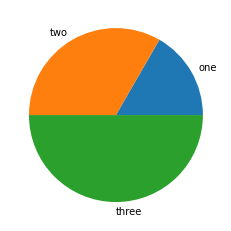

In [26]:
plt.pie([1, 2, 3], labels=["one", "two", "three"]);

- Di default i colori del grafico sono scelti automaticamente
- Si può impostare manualmente una lista di colori con l'attributo `colors`
- I colori possono essere specificati [in vari modi](https://matplotlib.org/stable/tutorials/colors/colors.html), ad es. per nome, in notazione HTML/CSS o tupla di valori RGB

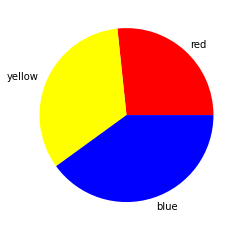

In [27]:
plt.pie(       [ 0.8,   1.0,       1.2           ],
        labels=[ "red", "yellow",  "blue"        ],
        colors=[ "red", "#ffff00", (0.0,0.0,1.0) ]);

- I grafici a torta sono usati per visualizzare la distribuzione di valori categorici
- Estraiamo ad esempio la colonna `sex` e i conteggi dei valori con `value_counts`

In [28]:
sex_counts = tips["sex"].value_counts()
sex_counts

Male      157
Female     87
Name: sex, dtype: int64

- Possiamo usare la funzione `pie` per visualizzare tale distribuzione in un grafico a torta...

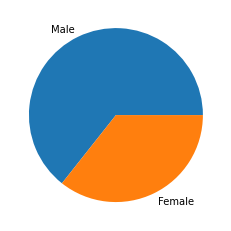

In [29]:
plt.pie(
    sex_counts,
    labels=sex_counts.index,
);

- ...o usare direttamente il metodo `plot.pie` della serie

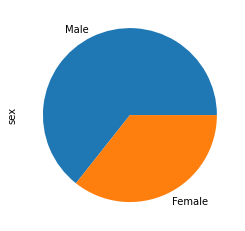

In [30]:
sex_counts.plot.pie();

- Per personalizzare i colori, possiamo definire un dizionario che associa ad ogni classe un colore da utilizzare...

In [31]:
sex_plot_colors = {"Female": "pink", "Male": "lightblue"}

- ...utilizzare il metodo `map` della serie per convertire il vettore dei nomi in un vettore dei colori...

In [32]:
sex_counts.index.to_list()

['Male', 'Female']

In [33]:
sex_counts.index.map(sex_plot_colors).to_list()

['lightblue', 'pink']

- ...e passarlo come parametro `colors` della funzione o del metodo

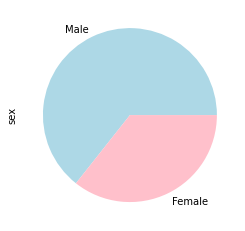

In [34]:
sex_counts.plot.pie(colors=sex_counts.index.map(sex_plot_colors));

- Possiamo visualizzare un grafico a torta anche di una serie numerica continua, discretizzandone i valori con `cut`
- Ad esempio questo grafico evidenzia la presenza di poche mance alte

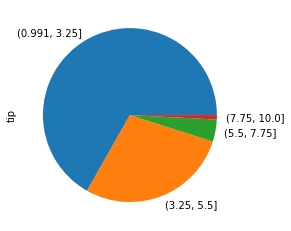

In [35]:
pd.cut(tips["tip"], 4).value_counts().plot.pie();

- Un grafico a torta può essere personalizzato passando parametri alla funzione o al metodo `pie`
- Ad es. `autopct=X` visualizza su ogni sezione le percentuali corrispondenti con un formato specificato
  - `%.2f` = percentuale con 2 cifre decimali, `%%` = simbolo "%"

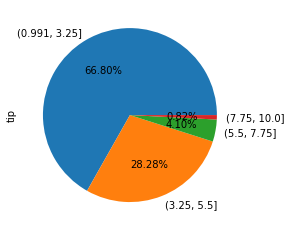

In [36]:
pd.cut(tips["tip"], 4).value_counts().plot.pie(autopct="%.2f%%");

### Grafico a barre

- Abbiamo visto nel lab precedente come usare un grafico a barre per confrontare tra loro singoli valori
- Possiamo usarlo anche per visualizzare la distribuzione di valori categorici, come alternativa ad un grafico a torta
- Applichiamo il metodo `plot.bar` al conteggio dei valori della colonna `day`

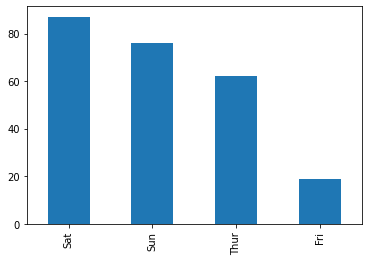

In [37]:
tips["day"].value_counts().plot.bar();

### Istogramma

- Un istogramma visualizza in un diagramma a barre la distribuzione di valori in una serie numerica
- Possiamo crearlo suddividendo i valori in intervalli di pari ampiezza (come per `pd.cut`) e indicando il numero di valori in ciascun intervallo in un grafico a barre

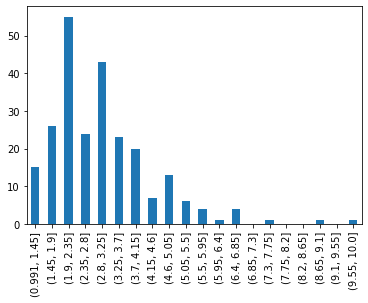

In [38]:
(
    pd.cut(tips["tip"], bins=20)  # discretizzo i valori
    .value_counts()               # estraggo i conteggi
    .sort_index()                 # devo ordinare i valori per etichetta!
    .plot.bar()
);

- È però più conveniente usare la funzione `hist`, a cui passare direttamente i dati e il numero di fasce da creare `bins` (default 10)...

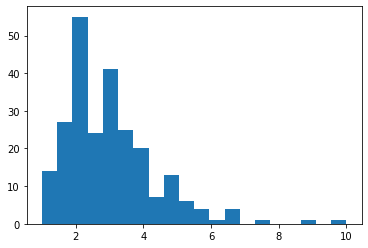

In [39]:
plt.hist(tips["tip"], bins=20);

- ...oppure il metodo equivalente `plot.hist`

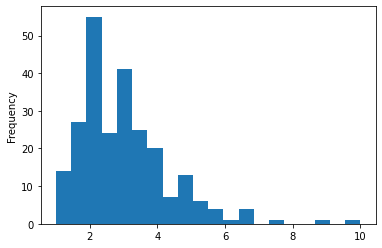

In [40]:
tips["tip"].plot.hist(bins=20);

- Dall'istogramma vediamo ad occhio (come indicato in parte dall'output di `describe`) che la maggior parte delle mance sono comprese tra 2\\$ e 3,5\\$, ma c'è una "coda" di mance fino a 10\\$

### Box plot

- Abbiamo visto nello scorso lab il _box plot_ come metodo per visualizzare le statistiche essenziali di una serie di valori

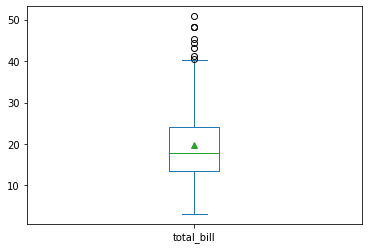

In [41]:
tips["total_bill"].plot.box(showmeans=True);

- Il rettangolo evidenzia che il 50\% "centrale" dei conti è tra i 15\\$ **(25%)** e i 25\\$ **(75%)** circa
- Il triangolo (20\\$) e la linea centrale (18\\$) indicano rispettivamente **media** e **mediana (50%)**
- I "baffi" indicano il **minimo** (2\\$) e il **massimo** (40\\$) dei dati "ordinari"
- I valori molto fuori dalla norma (_outlier_) sono mostrati come cerchi esterni ai baffi

- Possiamo invocare `plot.box` su un frame per visualizzare i box di tutte le colonne numeriche in un solo grafico
  - però se i valori sono su scale diverse come in questo caso, alcuni box plot risultano schiacciati

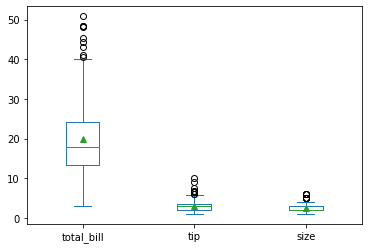

In [42]:
tips.plot.box(showmeans=True);

- I frame forniscono anche il metodo `boxplot` con alcune funzioni aggiuntive
  - con `column` si specifica di quale colonna mostrare il grafico
  - con `by` si partizionano i dati secondo il valore di un'altra colonna e si mostra il box plot per gruppi
- Vediamo ad esempio la distribuzione delle mance differenziata per giorno della settimana

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


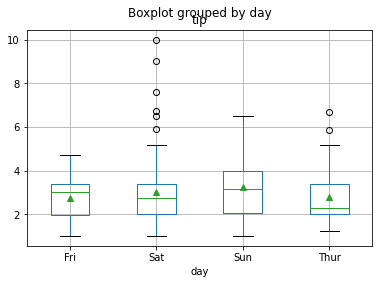

In [43]:
tips.boxplot(column="tip", by="day", showmeans=True);

### Grafico a dispersione

- Un grafico a dispersione (_scatter plot_) visualizza dei punti in un piano
- Si crea con la funzione `scatter`, passando due vettori di pari lunghezza con rispettivamente i valori per le coordinate X e Y di ciascun punto

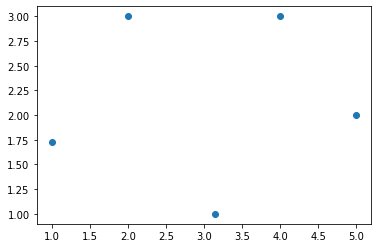

In [44]:
plt.scatter(
    [1,    2, 3.14, 4, 5],   # X
    [1.73, 3, 1,    3, 2],   # Y
);

- Un grafico a dispersione può essere usato per visualizzare la distribuzione di due variabili in modo congiunto
- In questo modo è possibile **valutare se esiste una correlazione** tra tali due variabili
- Vediamo ad esempio la correlazione tra totale del conto (asse X) e mancia lasciata (asse Y)

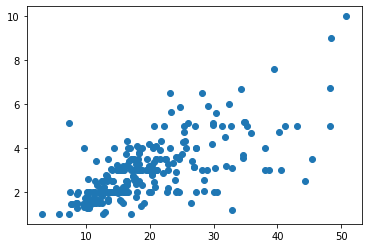

In [45]:
plt.scatter(
    tips["total_bill"],  # X
    tips["tip"],         # Y
);

- Possiamo ottenere lo stesso grafico col metodo `plot.scatter` sul frame, specificando i nomi delle colonne da usare come X e Y

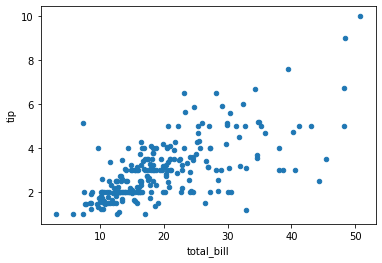

In [46]:
tips.plot.scatter("total_bill", "tip");

- Il grafico evidenzia visivamente che in tendenza la mancia è (come prevedibile) tanto più alta quanto lo è il totale da pagare

- I parametri `s` (size) e `c` (col) di `scatter` permettono di decidere dimensione e colore dei punti
- Si può facilmente assegnare la stessa dimensione e/o colore a tutti i punti...

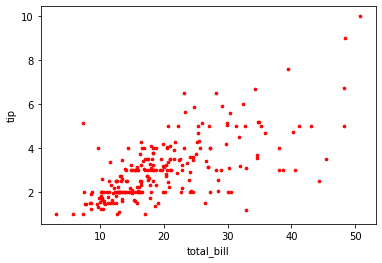

In [47]:
tips.plot.scatter("total_bill", "tip", s=7, c="red");

- Si possono però anche differenziare dimensioni e colori in base ai singoli punti, passando a `s` e `c` una serie di valori

- Ad esempio, creiamo un grafico con dimensioni dei punti corrispondenti al numero di persone e colori diversificati per pranzi e cene
  - a `s` passiamo i valori di `size` in scala esponenziale per differenziare meglio le dimensioni
  - a `c` passiamo una serie col colore di ciascun punto ottenuta col metodo `map`

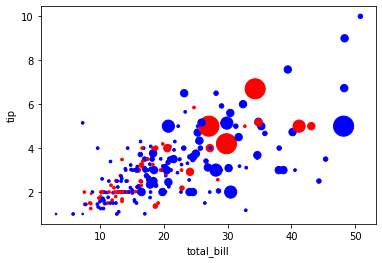

In [48]:
time_colors = {"Lunch": "red", "Dinner": "blue"}

tips.plot.scatter(
    "total_bill",                     # X
    "tip",                            # Y
    s=np.exp(tips["size"]),           # dimensione
    c=tips["time"].map(time_colors)   # colore
);

- Se come colore viene indicata una colonna numerica, viene usata una _colormap_ per mappare i valori numerici a colori secondo una scala
  - esistono [molte colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) integrate in matplotlib ed è possibile [crearne nuove](https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html)

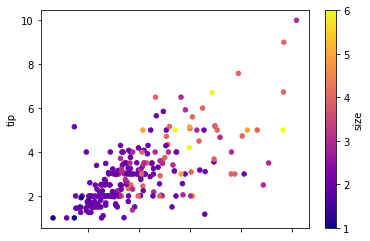

In [49]:
tips.plot.scatter("total_bill", "tip", c="size", colormap="plasma");

### Personalizzazione dei grafici

Abbiamo visto nello scorso lab alcuni metodi per personalizzare i grafici:
- il parametro `figsize` può essere usato nei metodi `plot.*` per stabilire la dimensione della figura come una tupla `(larghezza, altezza)`
- le funzioni `xlabel` e `ylabel` impostano le etichette degli assi
- la funzione `title` (o il parametro `title` nei metodi `plot.*`) imposta un titolo visualizzato sopra il grafico

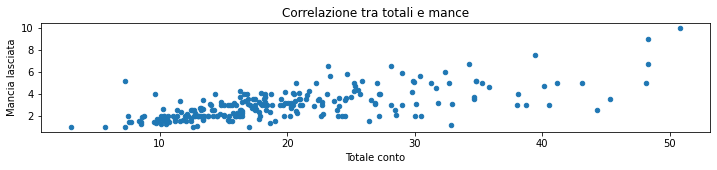

In [50]:
tips.plot.scatter("total_bill", "tip", figsize=(12, 2))
plt.title("Correlazione tra totali e mance")
plt.xlabel("Totale conto")
plt.ylabel("Mancia lasciata");

### Figure con grafici multipli

- matplotlib permette di disporre a griglia molteplici grafici in una figura
- Per riferirsi ad una porzione di grafico usare la funzione `subplot` indicando in ordine il numero di righe, il numero di colonne e l'indice della porzione (numerate da 1)
- Sul risultato di `subplot` possono essere invocate le funzioni per creare i singoli grafici
- Creiamo ad esempio una figura con 3 grafici di diverso tipo in una riga
  - Chiamando la funzione `figure` prima definiamo gli attributi della figura, in questo caso la dimensione

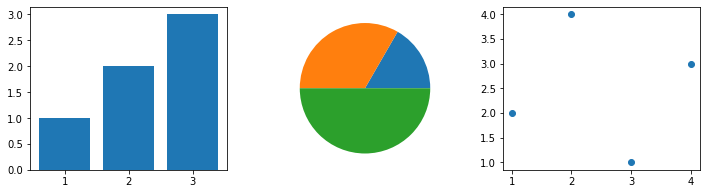

In [51]:
plt.figure(figsize=(12, 3))
# plt.subplot(numero di righe, numero di colonne, indice)
plt.subplot(1, 3, 1).bar([1, 2, 3], [1, 2, 3])
plt.subplot(1, 3, 2).pie([1, 2, 3]);
plt.subplot(1, 3, 3).scatter([1, 2, 3, 4], [2, 4, 1, 3]);

- Per inserire grafici creati tramite pandas in un `subplot`, indicarlo come parametro `ax` nel metodo `plot.*` utilizzato
- Creiamo ad esempio una griglia con i bar plot di tutte le variabili categoriche

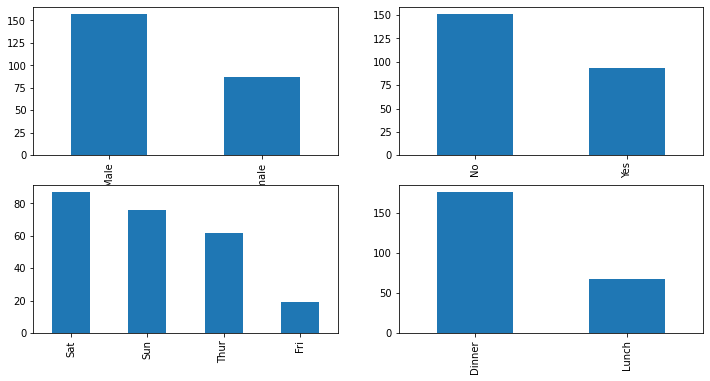

In [52]:
plt.figure(figsize=(12, 6))
tips["sex"]   .value_counts().plot.bar(ax=plt.subplot(2, 2, 1))
tips["smoker"].value_counts().plot.bar(ax=plt.subplot(2, 2, 2))
tips["day"]   .value_counts().plot.bar(ax=plt.subplot(2, 2, 3))
tips["time"]  .value_counts().plot.bar(ax=plt.subplot(2, 2, 4));

- Per evitare ripetizioni di codice, sfruttiamo un ciclo `for` con la funzione `enumerate` per generare gli indici
  - `enumerate([A, B, C, ...], start=1)` -> `(1, A), (2, B), (3, C), ...`

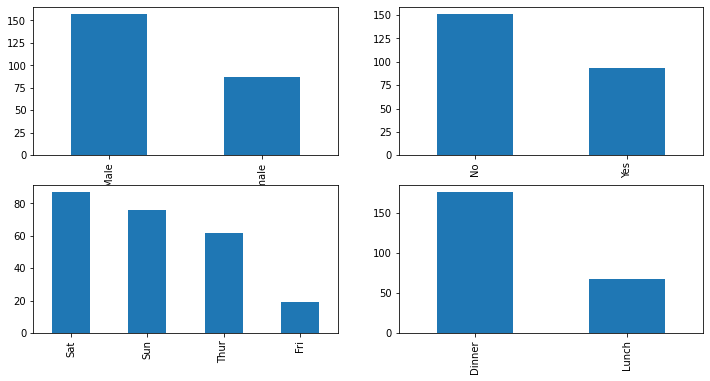

In [53]:
plt.figure(figsize=(12, 6))
for n, col in enumerate(["sex", "smoker", "day", "time"], start=1):
    tips[col].value_counts().plot.bar(ax=plt.subplot(2, 2, n))

### Esercizio 3: Grafici

Creare i seguenti grafici:
- **(3a)** un grafico a torta con la distribuzione dei totali dei conti in tre fasce di uguale ampiezza
- **(3b)** un grafico a torta con la distribuzione delle sole cene (`time="Dinner"`) per giorno della settimana
- **(3c)** un'istogramma con la distribuzione del rapporto tra mancia e totale del conto
- **(3d)** un box plot con la stessa distribuzione (3c)
- **(3e)** un grafico a dispersione con la correlazione tra mancia lasciata e numero di persone al tavolo
- **(3f)** una figura con un grafico a barre con la distribuzione di tavoli fumatori e non per ciascun giorno della settimana

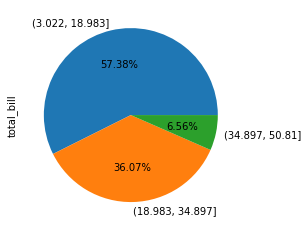

In [54]:
pd.cut(tips["total_bill"], 3).value_counts().plot.pie(autopct="%.2f%%")

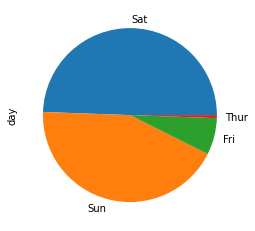

In [55]:
tips[tips["time"]=="Dinner"]["day"].value_counts().plot.pie()

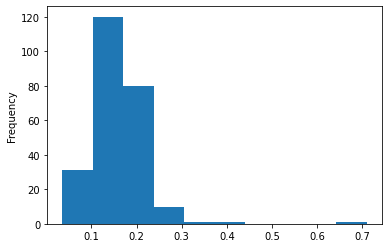

In [56]:
(tips["tip"]/tips["total_bill"]).plot.hist()

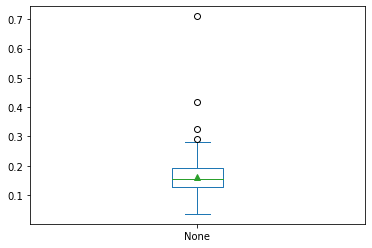

In [57]:
(tips["tip"]/tips["total_bill"]).plot.box(showmeans=True)

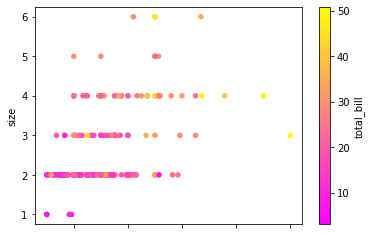

In [58]:
tips.plot.scatter("tip", "size", c="total_bill", colormap="spring")

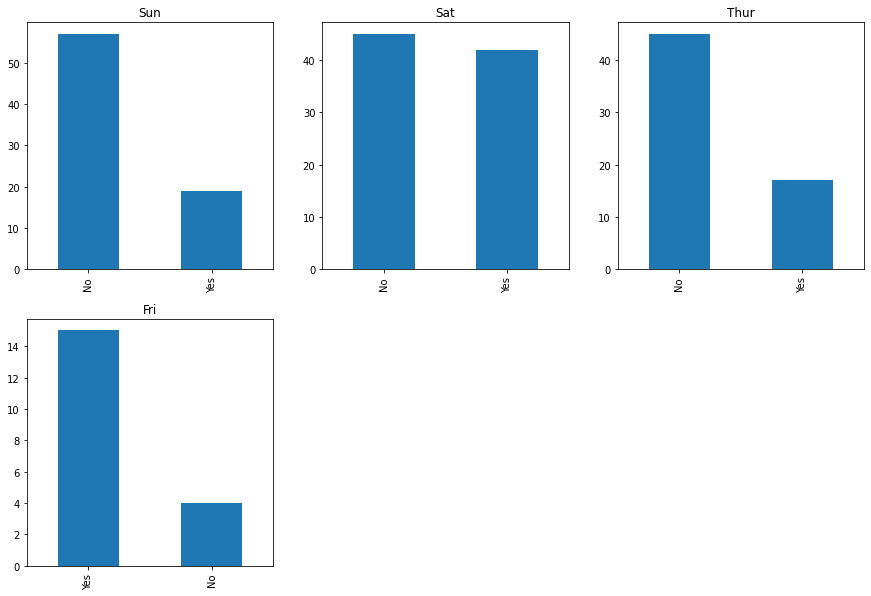

In [59]:
days = tips["day"].unique()
for i, day in enumerate(days, start=1):
  tips.loc[tips["day"]==day ,"smoker"].value_counts().plot.bar(ax=plt.subplot(2,3,i), title=day, figsize=(15,10))

## Raggruppamento

- Abbiamo visto come calcolare statistiche (somma, media, ...) ed eseguire altre operazioni sugli interi DataFrame
- È però spesso opportuno estrarre statistiche simili separate per gruppi di dati
- **Esempio:** qual'è la media delle mance per ogni giorno della settimana?
- Possiamo ottenere questa informazione con i metodi visti finora, ma in modo non del tutto immediato...

In [60]:
for x in tips["day"].unique():
    mean_tips_on_x = tips.loc[tips["day"] == x, "tip"].mean()
    print(f"{x:>4}: {mean_tips_on_x:6.2f}")

 Sun:   3.26
 Sat:   2.99
Thur:   2.77
 Fri:   2.73


- I `DataFrame` possono essere partizionati in due o più **gruppi** di righe
- I gruppi sono definiti in base ai valori in **una o più colonne _chiave_** o a valori derivati da esse
- Sul frame partizionato è possibile compiere operazioni **separatamente sui singoli gruppi**, in particolare ottenere statistiche separate per gruppo

### Raggruppamento su colonna singola

- Come primo esempio, definiamo una partizione in base al valore della singola colonna `time`, che distingue i tavoli per pranzo ("Lunch") e cena ("Dinner")
- Usiamo il metodo `groupby` indicando il nome della colonna

In [61]:
tips.groupby("time")

- La partizione così creata contiene due gruppi, come verificabile dall'attributo `ngroups`

In [62]:
tips.groupby("time").ngroups

2

- Il dizionario `groups` contiene gli indici delle righe di ciascun gruppo
- Le chiavi sono i nomi dei gruppi, corrispondenti ai valori della colonna di raggruppamento

In [63]:
list(tips.groupby("time").groups.keys())

['Dinner', 'Lunch']

- `size` restituisce una serie col numero di righe in ciascun gruppo
  - equivalente in pratica a quella che otterremmo con `value_counts`

In [64]:
tips.groupby("time").size()

time
Dinner    176
Lunch      68
dtype: int64

- Sulla partizione è possibile chiamare i metodi di aggregazione già visti per ottenere **statistiche divise per gruppi**
- Chiamiamo ad esempio il metodo `mean` per il calcolo della media

In [65]:
tips.groupby("time").mean()

,total_bill,tip,size
time,,,
Dinner,20.797159,3.102670,2.630682
Lunch,17.168676,2.728088,2.411765


- Si ottiene un DataFrame con **una riga per ogni gruppo**, in cui sono riportate le medie di ciascuna colonna limitate a quel gruppo
- Si può vedere ad esempio che la mancia (`tip`) media è circa 3,10\\$ a cena e 2,73\\$ a pranzo

- Possiamo anche selezionare una singola colonna dal raggruppamento per ottenere statistiche per gruppi limitate ad essa

In [66]:
tips.groupby("time")["tip"].mean()

time
Dinner    3.102670
Lunch     2.728088
Name: tip, dtype: float64

- Possiamo usare `describe` o `agg` per ottenere statistiche multiple

In [67]:
tips.groupby("time")["tip"].describe()

,count,mean,std,min,25%,50%,75%,max
time,,,,,,,,
Dinner,176.0,3.102670,1.436243,1.00,2.0,3.00,3.6875,10.0
Lunch,68.0,2.728088,1.205345,1.25,2.0,2.25,3.2875,6.7


### Raggruppamento su valori derivati

- Oltre che su una colonna, i gruppi possono essere creati in base ad **altre serie con indice uguale** a quello del DataFrame, ad es. a variabili **derivate dalle colonne esistenti**
- Ipotizziamo ad esempio di voler distinguere tra tavoli "piccoli" con 4 persone al massimo e tavoli "grandi" con più persone
- Creiamo una serie booleana che indichi se il tavolo è "grande" o meno e la passiamo come argomento a `groupby`

In [68]:
large_table = tips["size"] > 4
tips.groupby(large_table)

- Otteniamo quindi una partizione nei gruppi `False` (tavoli piccoli) e `True` (tavoli grandi)

In [69]:
list(tips.groupby(large_table).groups.keys())

[False, True]

- Anche in questo caso possiamo calcolare statistiche per gruppo

In [70]:
tips.groupby(large_table).mean()

,total_bill,tip,size
size,,,
False,19.311106,2.938468,2.459574
True,32.184444,4.560000,5.444444


- Possiamo usare `map` per cambiare i valori della serie di raggruppamento e di conseguenza i nomi dei gruppi, in modo che siano più comprensibili

In [71]:
table_size = (tips["size"] > 4).map({True: "Large", False: "Small"})
tips.groupby(table_size).mean()

,total_bill,tip,size
size,,,
Large,32.184444,4.560000,5.444444
Small,19.311106,2.938468,2.459574


- Ovviamente nei tavoli più grandi sia il totale dei conti che le mance sono in media maggiori

### Chiavi di raggruppamento multiple

- Creiamo ora una partizione basata su due diverse colonne categoriche: `time` (pranzo o cena) e `smoker` (fumatori o non)
- Passiamo a `groupby` la lista dei nomi delle colonne

In [72]:
tips.groupby(["time", "smoker"])

- Abbiamo un totale di 2×2 = 4 gruppi possibili

In [73]:
list(tips.groupby(["time", "smoker"]).groups.keys())

[('Dinner', 'No'), ('Dinner', 'Yes'), ('Lunch', 'No'), ('Lunch', 'Yes')]

- Ciascun gruppo è identificato da una tupla di due valori corrispondenti alle due chiavi: ad esempio `('Dinner', 'No')` indica tavoli a cena di non fumatori

- Anche in questo caso possiamo calcolare le medie per ciascun gruppo

In [74]:
tips.groupby(["time", "smoker"]).mean()

total_bill       tip      size
time   smoker                                
Dinner No       20.095660  3.126887  2.735849
       Yes      21.859429  3.066000  2.471429
Lunch  No       17.050889  2.673778  2.511111
       Yes      17.399130  2.834348  2.217391

- Il frame ottenuto mostra un esempio di **indice delle righe a più livelli**: ciascuna riga è etichettata da una tupla di valori piuttosto che da uno come visto finora
- In questo esempio i livelli sono due, per cui ogni riga è identificata da una tupla di due elementi
- A ogni livello può essere associato un nome: quì i nomi (`time` e `smoker`) sono quelli delle colonne nel frame originale

- Anche una serie può avere un indice a più livelli
- Usiamo ad esempio `size` per ottenere il numero di elementi di ciascun gruppo

In [75]:
tips.groupby(["time", "smoker"]).size()

time    smoker
Dinner  No        106
        Yes        70
Lunch   No         45
        Yes        23
dtype: int64

- Abbiamo una serie di 4 valori, ciascuno etichettato da una coppia di elementi

- Per estrarre un singolo elemento dalla serie (o una singola riga dal DataFrame), specifichiamo l'etichetta in forma di tupla
  - nota: le parentesi tonde all'interno delle quadre sono opzionali

In [76]:
tips.groupby(["time", "smoker"]).size()[("Dinner", "No")]

106

- Possiamo specificare un'etichetta parziale per estrarre una porzione dei dati
  - ad esempio indichiamo `"Dinner"` per estrarre tutte le righe con etichetta `("Dinner", *)`
  - il livello `time` dell'indice sul quale è compiuta la selezione è rimosso dalla selezione, lasciando solo `smoker`

In [77]:
tips.groupby(["time", "smoker"]).size()["Dinner"]

smoker
No     106
Yes     70
dtype: int64

- Per filtrare sul secondo livello, possiamo specificare ":" al posto del primo

In [78]:
tips.groupby(["time", "smoker"]).size()[:, "No"]

time
Dinner    106
Lunch      45
dtype: int64

### Esercizio 4: `groupby`

Ottenere:
- **(4a)** una serie col numero di persone medio a tavoli con fumatori e non
- **(4b)** un frame col totale e la media delle mance per ciascun giorno della settimana
- **(4c)** una serie con la media delle mance ricevute di venerdì ("Fri"), suddivise tra pranzo e cena
- **(4d)** una serie con la media delle mance ricevute tra tavoli che hanno pagato almeno 20$ e quelli che han pagato di meno

In [79]:
tips.groupby("smoker")["size"].mean()

smoker
No     2.668874
Yes    2.408602
Name: size, dtype: float64

In [80]:
tips.groupby("day")["tip"].agg(["mean", "sum"])

,mean,sum
day,,
Fri,2.734737,51.96
Sat,2.993103,260.40
Sun,3.255132,247.39
Thur,2.771452,171.83


In [96]:
tips.loc[tips["day"] == "Fri"].groupby("time")["tip"].mean()

time
Dinner    2.940000
Lunch     2.382857
Name: tip, dtype: float64

In [82]:
tips.groupby(tips["total_bill"] >= 20)["tip"].mean()

total_bill
False    2.383810
True     3.929485
Name: tip, dtype: float64

## Pivoting

- Le operazioni di _pivoting_ permettono di **riorganizzare i valori** contenuti in una serie o DataFrame **spostando i livelli degli indici**
- Un livello presente nell'indice della serie o delle righe del DataFrame può essere spostato nelle colonne o viceversa
- Sono definite due operazioni di base che si possono compiere su serie e DataFrame:
  - `stack` sposta un livello **dalle colonne alle righe**, per cui dati che erano affiancati vengono **impilati**, messi uno sopra l'altro ("stacked")
  - `unstack` compie l'operazione inversa, spostando un livello **dalle righe alle colonne** e rendendo **affiancati** dati che erano impilati

- Ad esempio, presa la serie con indice a due livelli ottenuta sopra...

In [83]:
size_by_time_smoker = tips.groupby(["time", "smoker"]).size()
size_by_time_smoker

time    smoker
Dinner  No        106
        Yes        70
Lunch   No         45
        Yes        23
dtype: int64

- ...posso usare `unstack` per ottenere un frame dove uno dei due livelli tra `time` e `smoker` rimane come indice delle righe e l'altro diventa indice delle colonne
- Ad esempio, imposto `smoker` come indice delle colonne per ottenere una tabella dove ogni riga corrisponde ad un valore di `time` e ogni colonna ad uno di `smoker`
- Il frame ha **gli stessi dati** della serie, ma **ridisposti in una tabella**

In [84]:
size_by_time_smoker.unstack("smoker")

smoker,No,Yes
time,,
Dinner,106,70
Lunch,45,23


- `stack` rappresenta l'operazione inversa: applicandola ottengo la serie originale

In [85]:
size_by_time_smoker.unstack("smoker").stack()

time    smoker
Dinner  No        106
        Yes        70
Lunch   No         45
        Yes        23
dtype: int64

- Il metodo `unstack` può essere chiamato anche su un DataFrame, introducendo più livelli di colonne
- Ad esempio, calcolando le medie per gruppo otteniamo un DataFrame con due livelli di righe (gli stessi della serie sopra) e uno di colonne (le colonne del DataFrame originale)

In [86]:
means_by_time_smoker = tips.groupby(["time", "smoker"]).mean()
means_by_time_smoker

total_bill       tip      size
time   smoker                                
Dinner No       20.095660  3.126887  2.735849
       Yes      21.859429  3.066000  2.471429
Lunch  No       17.050889  2.673778  2.511111
       Yes      17.399130  2.834348  2.217391

- Chiamando `unstack` possiamo far diventare ad es. `time` un livello di colonne

In [87]:
means_by_time_smoker.unstack("time")

total_bill                  tip                size          
time       Dinner      Lunch    Dinner     Lunch    Dinner     Lunch
smoker                                                              
No      20.095660  17.050889  3.126887  2.673778  2.735849  2.511111
Yes     21.859429  17.399130  3.066000  2.834348  2.471429  2.217391

- Con l'operazione inversa `stack` possiamo spostare un livello di colonne a livello di righe
- Ad esempio, sul frame con le medie, spostando l'unico livello di colonne otteniamo una serie con indice a tre livelli
  - si noti che il livello delle colonne non ha nome

In [88]:
means_by_time_smoker.stack()

time    smoker            
Dinner  No      total_bill    20.095660
                tip            3.126887
                size           2.735849
        Yes     total_bill    21.859429
                tip            3.066000
                size           2.471429
Lunch   No      total_bill    17.050889
                tip            2.673778
                size           2.511111
        Yes     total_bill    17.399130
                tip            2.834348
                size           2.217391
dtype: float64

- Il metodo `pivot_table` permette di creare rapidamente da un frame una tabella di valori aggregati specificando
  - le colonne da usare come valori (`values`, default: tutte le colonne numeriche)
  - le colonne da usare come livelli di righe (`index`) e di colonne (`columns`)
  - una o più funzioni con cui aggregare i dati (`aggfunc`, default: "mean", media), sono valide le stesse viste in "agg"
- Ad esempio, per ottenere la tabella delle medie sopra con `smoker` = No/Yes sulle righe invece di...

In [89]:
tips.groupby(["time", "smoker"]).mean().unstack("time")

total_bill                  tip                size          
time       Dinner      Lunch    Dinner     Lunch    Dinner     Lunch
smoker                                                              
No      20.095660  17.050889  3.126887  2.673778  2.735849  2.511111
Yes     21.859429  17.399130  3.066000  2.834348  2.471429  2.217391

- ...possiamo scrivere

In [90]:
tips.pivot_table(index="smoker", columns="time")   # default: aggfunc="mean"

size                 tip           total_bill           
time      Dinner     Lunch    Dinner     Lunch     Dinner      Lunch
smoker                                                              
No      2.735849  2.511111  3.126887  2.673778  20.095660  17.050889
Yes     2.471429  2.217391  3.066000  2.834348  21.859429  17.399130

- Possiamo aggiungere l'opzione `margins=True` per visualizzare righe e colonne con aggregazioni parziali e totali
  - l'etichetta "All" di default può essere cambiata col parametro `margins_name`

In [91]:
tips.pivot_table(index="smoker", columns="time", margins=True)

size                           tip                     total_bill  \
time      Dinner     Lunch       All    Dinner     Lunch       All     Dinner   
smoker                                                                          
No      2.735849  2.511111  2.668874  3.126887  2.673778  2.991854  20.095660   
Yes     2.471429  2.217391  2.408602  3.066000  2.834348  3.008710  21.859429   
All     2.630682  2.411765  2.569672  3.102670  2.728088  2.998279  20.797159   

                              
time        Lunch        All  
smoker                        
No      17.050889  19.188278  
Yes     17.399130  20.756344  
All     17.168676  19.785943

- Ad esempio il 3°, 6° e 9° valore dell'ultima riga corrispondono alle medie complessive sulle tre colonne che abbiamo estratto all'inizio con `describe`

- Altro esempio: una tabella con le medie delle sole mance, raggruppate per giorno (righe) e per distinzione tra tavoli con più di 4 persone e non (colonne)
  - col metodo `rename` è possibile assegnare un nome significativo ("is large") ad una serie e di conseguenza al livello delle colonne

In [92]:
tips.pivot_table(
    values="tip",
    index="day",
    columns=(tips["size"] > 4).rename("is large"),
    aggfunc="mean",
)

is large,False,True
day,,
Fri,2.734737,NaN
Sat,2.993023,3.000
Sun,3.197917,4.285
Thur,2.602241,5.225


- Nei dati non c'è alcun esempio di tavoli grandi (colonna `True`) di venerdì (riga `Fri`): nella cella corrispondente abbiamo un valore mancante (NaN)
- In `stack`, `unstack` e `pivot_table` si può specificare `fill_value=X` per inserire un valore X (es. 0) al posto dei NaN

In [93]:
tips.pivot_table(
    values="tip",
    index="day",
    columns=(tips["size"] > 4).rename("is large"),
    aggfunc="mean",
    fill_value=0,
)

is large,False,True
day,,
Fri,2.734737,0.000
Sat,2.993023,3.000
Sun,3.197917,4.285
Thur,2.602241,5.225


- Altro esempio: una tabella con le medie e deviazioni standard delle mance, raggruppate per giorno e pasto (righe) e presenza o no di fumatori (colonne)

In [94]:
tips.pivot_table(
    values="tip",
    index=["day", "time"],
    columns="smoker",
    aggfunc=["mean", "std"],
)

mean                 std          
smoker             No       Yes        No       Yes
day  time                                          
Fri  Dinner  2.750000  3.003333  1.089725  1.234038
     Lunch   3.000000  2.280000       NaN  0.662239
Sat  Dinner  3.102889  2.875476  1.642088  1.630580
Sun  Dinner  3.167895  3.516842  1.224785  1.261151
Thur Dinner  3.000000       NaN       NaN       NaN
     Lunch   2.666364  3.030000  1.296821  1.113491

- Se in intere righe o colonne risulterebbero valori mancanti, queste sono omesse dal frame
  - qui ad es. mancano le righe dei pranzi di sabato e domenica

### Esercizio 5: Pivoting

- **(5a)** Ottenere tramite `groupby` un frame col numero di conti per ogni giorno della settimana lungo le righe e ogni pasto lungo le colonne
- **(5b)** Ottenere tramite `pivot_table` un frame col totale di mance ottenute per ogni giorno della settimana lungo le righe e ogni pasto lungo le colonne
- **(5c)** Dividere i totali dei conti in tre fasce di uguale ampiezza ed ottenere un frame con una riga per ciascuna fascia che riporti la media di totali e mance divise per pranzi e cene

In [103]:
tips.groupby(["day", "time"]).size().unstack("time")

time,Dinner,Lunch
day,,
Fri,12,7
Sat,87,0
Sun,76,0
Thur,1,61


In [104]:
tips.pivot_table(values="tip", index="day", columns="time", aggfunc="sum")

time,Dinner,Lunch
day,,
Fri,35.28,16.68
Sat,260.40,0.00
Sun,247.39,0.00
Thur,3.00,168.83


In [110]:
tips.pivot_table(values=["total_bill", "tip"], index=pd.cut(tips["total_bill"], 3), columns="time" , aggfunc="mean")

tip           total_bill           
time                Dinner     Lunch     Dinner      Lunch
total_bill                                                
(3.022, 18.983]   2.413516  2.253265  14.057692  13.351224
(18.983, 34.897]  3.587746  3.829412  25.208169  25.232941
(34.897, 50.81]   5.122143  5.000000  42.233571  42.150000